In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import math
%matplotlib inline

For each day, we count the searches mapped to each of these symptoms and organize the data by geographic region. The resulting dataset is a daily or weekly time series for each region showing the relative frequency of searches for each symptom.

## Preparing Dataset

In [2]:
F = pd.read_csv('data/current/2020_country_daily_2020_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F.columns = ['date', 'open_covid_region_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F = F[F['open_covid_region_code'].notna()]
F = F.sort_values(by=['open_covid_region_code'])
F = F.fillna(0)

In [3]:
F_2021 = pd.read_csv('data/current/2021_country_daily_2021_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F_2021.columns = ['date', 'open_covid_region_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F_2021 = F_2021[F_2021['open_covid_region_code'].notna()]
F_2021 = F_2021.sort_values(by=['open_covid_region_code'])
F_2021 = F_2021.fillna(0)

In [4]:
actual_cases = pd.read_csv('data/all-states-history.csv')[['date','state','positiveIncrease']]

In [5]:
# EXLCUDING: AS(America Samoa), GU(Guam), MP(Northern Mariana Islands), PR(Puerto Rico), VI(Virgin Islands)
OVERLAPPING_STATES = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 
                      'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 
                      'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 
                      'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

actual_cases = actual_cases[actual_cases['state'].isin(OVERLAPPING_STATES)]
unique_dates = actual_cases['date'].unique()

lacking = []
for date in unique_dates:
    if len(actual_cases[actual_cases.date == date]) == 51:
        continue
    else: 
        lacking.append(date)
        
print("last date without full 51 states: ", max(lacking))
actual_cases = actual_cases[actual_cases.date > '2020-03-06'].sort_values(by=['date', 'state'], ascending=True)


last date without full 51 states:  2020-03-06


#### Actual Data for Testing

In [6]:
actual_cases_testing = pd.read_csv('data/all-states-history_till_MARCH.csv')[['date','state','positiveIncrease']]
actual_cases_testing = actual_cases_testing[actual_cases_testing['state'].isin(OVERLAPPING_STATES)]
unique_dates = actual_cases_testing['date'].unique()
lacking = []
for date in unique_dates:
    if len(actual_cases_testing[actual_cases_testing.date == date]) == 51:
        continue
    else: 
        lacking.append(date)
print("last date without full 51 states: ", max(lacking))
actual_cases_testing = actual_cases_testing[actual_cases_testing.date > '2020-03-06'].sort_values(by=['date', 'state'], ascending=True)
print("max day is", max(actual_cases_testing.date))

last date without full 51 states:  2020-03-06
max day is 2021-03-07


Checking new data

In [7]:
NUM_STATES = F.open_covid_region_code.nunique()
assert NUM_STATES == 51, "NUM_STATES ERROR"
STATES = F.open_covid_region_code.unique()
SYMP_LIST = ['symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 
             'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 
             'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 
             'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
NUM_SYMP = len(SYMP_LIST)
assert NUM_SYMP == 17, "NUM SYMP ERROR"

In [8]:
BORDER_DICT = {
    'US-AK': [],
    'US-AL': ['US-MI', 'US-TN', 'US-GA', 'US-FL'],
    'US-AR': ['US-OK', 'US-TX', 'US-MO', 'US-TN', 'US-MS', 'US-LA'],
    'US-AZ': ['US-NM', 'US-UT', 'US-NV', 'US-CA'],
    'US-CA': ['US-OR', 'US-NV', 'US-AZ'],
    'US-CO': ['US-WY', 'US-NE', 'US-KS', 'US-OK', 'US-NM', 'US-UT'],
    'US-CT': ['US-RI', 'US-MA', 'US-NY'],
    'US-DC': ['US-MD', 'US-VA'],
    'US-DE': ['US-PA', 'US-NJ', 'US-MD'],
    'US-FL': ['US-AL', 'US-GA'],
    'US-GA': ['US-FL', 'US-AL', 'US-TN', 'US-NC', 'US-SC'],
    'US-HI': [],
    'US-IA': ['US-MN', 'US-WI', 'US-IL', 'US-MO', 'US-NE', 'US-SD'],
    'US-ID': ['US-OR', 'US-NV', 'US-UT', 'US-WY', 'US-MT', 'US-WA'],
    'US-IL': ['US-IA', 'US-MO', 'US-KY', 'US-IN', 'US-WI'],
    'US-IN': ['US-MI', 'US-OH', 'US-KY', 'US-LI'],
    'US-KS': ['US-CO', 'US-NE', 'US-MO', 'US-OK'],
    'US-KY': ['US-IL', 'US-IN', 'US-OH', 'US-WV', 'US-VA', 'US-TN', 'US-MO'],
    'US-LA': ['US-TX', 'US-AR', 'US-MS'],
    'US-MA': ['US-NH', 'US-VT', 'US-NY', 'US-RI', 'US-CT'],
    'US-MD': ['US-DE', 'US-VA', 'US-WV', 'US-PA'],
    'US-ME': ['US-NH'],
    'US-MI': ['US-WI', 'US-IN', 'US-OH'],
    'US-MN': ['US-ND', 'US-SD', 'US-IA', 'US-WI'],
    'US-MO': ['US-IA', 'US-IL', 'US-KY', 'US-TN', 'US-AR', 'US-OK', 'US-KS', 'US-NE'], 
    'US-MS': ['US-AL', 'US-TN', 'US-AR', 'US-LA'],
    'US-MT': ['US-ID', 'US-WY', 'US-SD', 'US-ND'],
    'US-NC': ['US-VA', 'US-TN', 'US-GA', 'US-SC'],
    'US-ND': ['US-MT', 'US-SD', 'US-MN'],
    'US-NE': ['US-SD', 'US-IA', 'US-MO', 'US-KS', 'US-CO', 'US-WY'],
    'US-NH': ['US-ME', 'US-VT', 'US-MA'],
    'US-NJ': ['US-PA', 'US-DE', 'US-NY'],
    'US-NM': ['US-AZ', 'US-CO', 'US-OK', 'US-TX'],
    'US-NV': ['US-CA', 'US-OR', 'US-ID', 'US-UT', 'US-AZ'],
    'US-NY': ['US-VT', 'US-MA', 'US-CT', 'US-NJ', 'US-PA'],
    'US-OH': ['US-MI', 'US-IN', 'US-KY', 'US-WV', 'US-PA'],
    'US-OK': ['US-TX', 'US-AR', 'US-MO', 'US-KS', 'US-CO', 'US-NM'],
    'US-OR': ['US-WA', 'US-ID', 'US-NV', 'US-CA'],
    'US-PA': ['US-NJ', 'US-NY', 'US-DE', 'US-MD', 'US-WV', 'US-OH'], 
    'US-RI': ['US-MA', 'US-CT'],
    'US-SC': ['US-NC', 'US-GA'],
    'US-SD': ['US-ND', 'US-MN', 'US-IA', 'US-NE', 'US-WY', 'US-MT'], 
    'US-TN': ['US-KY', 'US-VA', 'US-NC', 'US-GA', 'US-AL', 'US-MS', 'US-AR', 'US-MO'],
    'US-TX': ['US-NM', 'US-OK', 'US-AR', 'US-LA'],
    'US-UT': ['US-NV', 'US-AZ', 'US-CO', 'US-WY', 'US-ID'],
    'US-VA': ['US-WV', 'US-MD', 'US-KY', 'US-TN', 'US-NC'], 
    'US-VT': ['US-NH', 'US-MA', 'US-NY'],
    'US-WA': ['US-OR', 'US-ID'],
    'US-WI': ['US-MI', 'US-IL', 'US-IA', 'US-MN'],
    'US-WV': ['US-OH', 'US-PA', 'US-MD', 'US-VA'],
    'US-WY': ['US-ID', 'US-MT', 'US-SD', 'US-NE', 'US-CO', 'US-UT']
}

## Obtaining Weights & Intercept

In [9]:
# ctrl_region_symp (Fsdn), Ysdn
# target_region_symp (Fsdrt)
def beta(ctrl_region_symp, Ysdn):
    numerator = NUM_SYMP * np.sum(np.multiply(ctrl_region_symp,Ysdn)) - (np.multiply(np.sum(ctrl_region_symp), np.sum(Ysdn)))
    denominator = NUM_SYMP * np.sum(np.square(ctrl_region_symp)) - np.square(np.sum(ctrl_region_symp))
    return numerator / denominator

def epsilon(ctrl_region_symp, Ysdn, beta):
    numerator = np.sum(Ysdn) - (beta * np.sum(ctrl_region_symp))
    return numerator / NUM_SYMP

def R2(e2_list, target_region_symp, mean_symp_rate):
#     mean_symp_rate = np.mean(target_region_symp)
    numerator = np.sum(e2_list)
    denominator = np.sum(np.square(target_region_symp - mean_symp_rate))
    return 1 - (numerator/denominator)

# Returns an array of control states
def get_ctrl_states(target_region):
    index = np.where(STATES != target_region)
    ctrl_states_pool = STATES[index]
    ctrl_states_pool = np.setdiff1d(ctrl_states_pool, BORDER_DICT[target_region])
    return ctrl_states_pool

In [10]:
# F_data = F filtered down to a single date
# data = F_data without target region row

def obtain_weights(F_data, target_region):
    CTRL_REGIONS = get_ctrl_states(target_region)
    data = F_data[F_data.open_covid_region_code.isin(CTRL_REGIONS)]

    target_region = F_data[F_data.open_covid_region_code == target_region]
    target_region_symp_rates = target_region[SYMP_LIST].to_numpy().flatten()
    mean_target_symp_rates = np.mean(target_region_symp_rates)
    
    best_ctrl_region_list = []
    beta_control = np.zeros(5)
    epsilon_control = np.zeros(5)
    mju_list = np.zeros((5, NUM_SYMP))
    best_e2 = np.zeros(5)
    
    for n in range(5):
        R2_list = np.zeros(len(CTRL_REGIONS))
        
        Ysdn = target_region_symp_rates - mju_list[n-1]
        mean_Ysdn = np.mean(Ysdn)
        beta_list = np.zeros(len(CTRL_REGIONS))
        epsilon_list = np.zeros(len(CTRL_REGIONS))
        
        for idx_r, region in enumerate(CTRL_REGIONS):
            region_row = data[data.open_covid_region_code == region]
            region_symp_rates = region_row[SYMP_LIST].to_numpy().flatten()
            
            beta_region = beta(region_symp_rates, Ysdn)
            epsilon_region = epsilon(region_symp_rates, Ysdn, beta_region)
            beta_list[idx_r] = beta_region
            epsilon_list[idx_r] = epsilon_region
                   
            F_hat_s = np.multiply(beta_region, region_symp_rates) + epsilon_region
            e2_list = np.square(Ysdn - F_hat_s)
            
            R2_region = R2(e2_list, Ysdn, mean_Ysdn)
            R2_list[idx_r] = R2_region
        
        best_ctrl_region_idx = R2_list.argmax()
        best_ctrl_region_list.append(CTRL_REGIONS[best_ctrl_region_idx])
        
        CTRL_REGIONS = np.delete(CTRL_REGIONS, best_ctrl_region_idx)
        
        beta_control[n] = beta_list[best_ctrl_region_idx]
        epsilon_control[n] = epsilon_list[best_ctrl_region_idx]
        
        best_region_row = data[data.open_covid_region_code == best_ctrl_region_list[-1]]
        best_region_row = best_region_row[SYMP_LIST].to_numpy().flatten()
        F_hat_s = np.multiply(beta_control[n], best_region_row) + epsilon_control[n]
        
        mju_list[n] = F_hat_s + mju_list[n-1]
        e2 = np.sum(np.square(Ysdn - F_hat_s))
        best_e2[n] = e2
    return best_ctrl_region_list, beta_control, epsilon_control, best_e2
   

### Predicting Symptom Rates

In [11]:
def pred_single_symp_rate(F_data_symp, best_ctrl_regions, beta_control, epsilon_control):
    # F_data_symp = F filtered down to a single date & single symptom column
    F_hat_s = 0
    for i in range(5):
        ctrl_region_symp_rate = F_data_symp[F_data_symp.open_covid_region_code == best_ctrl_regions[i]].to_numpy().flatten()[1] 
        F_hat_s = F_hat_s + beta_control[i] * ctrl_region_symp_rate
    F_hat_s = F_hat_s + np.sum(epsilon_control)
    return F_hat_s

def pred_all_symp_rates(F, date, best_ctrl_regions, beta_control, epsilon_control):
    # Prediction of all 17 symptoms of target region 
    F_data = F[F.date == date]
    F_hat_s_list = np.zeros(NUM_SYMP)
    for idx_s, symp in enumerate(SYMP_LIST):
        F_data_symp = F_data[['open_covid_region_code', symp]]
        F_hat_s = pred_single_symp_rate(F_data_symp, best_ctrl_regions, beta_control, epsilon_control)
        F_hat_s_list[idx_s] = F_hat_s
    return F_hat_s_list

# delta is [17,1]
def delta_symp(ground_truth_symp_rates, pred_symp_rates):
    delta = np.subtract(ground_truth_symp_rates, pred_symp_rates)
    return delta

In [12]:
def get_date(date):
    date_elems = [int(elem) for elem in date.split('-')]
    return datetime.datetime(date_elems[0], date_elems[1], date_elems[2])

# Extend start date back by one day for obtaining weights 
def prepare_date_range(start_date, end_date):
    start = get_date(start_date) + datetime.timedelta(days=-1)
    end = get_date(end_date)
    date_range = list(pd.date_range(start, end))
    date_range = [date.strftime('%Y-%m-%d') for date in date_range]
    return date_range

In [13]:
# Should return Delta Matrix = [period, region, symptoms]
def symptom_rate_pred_model(F, start_date, end_date):
    # date_range includes one extra day in the beginning 
    date_range = prepare_date_range(start_date, end_date)
    period = len(date_range)
    delta_mat = np.zeros((period, NUM_STATES, NUM_SYMP))
    
    # date_range[0] is first obtain weights date: start_date - 1
    # date_range[1] is first day of predictions, date_range[-1] is last day of predictions
    for idx_d, date in enumerate(date_range[:period-1]):
        pred_date = date_range[idx_d+1]
        # delta array of 51 states and their 17 symptoms on 1 day
        delta_day = np.zeros((NUM_STATES, NUM_SYMP))
        query_date_data = F[F.date == pred_date]
        obtain_weight_date = F[F.date == date]
        for idx_r, region in enumerate(STATES):
            actual_symp_rates = query_date_data[query_date_data.open_covid_region_code == region]
            best_ctrl_region_list, beta_control, epsilon_control, best_e2 = obtain_weights(obtain_weight_date, region)   

            F_hat_s_list = pred_all_symp_rates(F, pred_date, best_ctrl_region_list, beta_control, epsilon_control)
            actual_queries = actual_symp_rates.drop(['date', 'open_covid_region_code'], axis = 1).to_numpy().flatten()
            delta_region = delta_symp(actual_queries, F_hat_s_list)
     
            delta_day[idx_r] = delta_region      
        delta_mat[idx_d] = delta_day
    return delta_mat, period

### FROM HERE ON:
We are only looking at delta symptom: COUGH (idx 4) * FEVER (idx 7)

In [14]:
# New delta shape (period, region)
NEW_NUM_SYMP = 1
def new_delta_mat(delta_mat, period, idx_symp1, idx_symp2):
    new_delta_mat = np.zeros((period, NUM_STATES))
    for idx_d in range(period):
        # delta day shape (51,)
        delta_day = delta_mat[idx_d]
        delta_symp_1_2 = np.array([ np.multiply(delta_region[idx_symp1], delta_region[idx_symp2]) for delta_region in delta_day])
        new_delta_mat[idx_d] = delta_symp_1_2
    return new_delta_mat

# Symptom Rates Outbreak Detection

In [15]:
# Average delta of all days for each region
# delta mat shape (period, region)

def average_delta(period, delta_mat):
    ave_mat = np.zeros(NUM_STATES)
    for idx_r, delta_region in enumerate(delta_mat.transpose()):
        ave_region = np.mean(delta_region)
        ave_mat[idx_r] = ave_region
    return ave_mat

def std_dev_delta(period, delta_mat):
    std_mat = np.zeros(NUM_STATES)
    for idx_r, delta_region in enumerate(delta_mat.transpose()):
        std_region = np.std(delta_region)
        std_mat[idx_r] = std_region
    return std_mat

def z_score(delta_mat, ave_mat, std_mat, period):
    z_score = np.zeros((period, NUM_STATES))
    for idx_d, delta_day in enumerate(delta_mat):
        z_day = np.divide(np.subtract(delta_day, ave_mat), std_mat)
        z_score[idx_d] = z_day
    return z_score

def L_score(z_score, TH):
    L_score = z_score > TH
    return L_score.astype(int)

In [16]:
# period is the number of days that there are predictions (not including extra day for obtaining weights)
# pred outbreak sr ALL states
def pred_outbreak_detection(delta_mat, period, TH):
    ave_mat = average_delta(period, delta_mat)
    std_mat = std_dev_delta(period, delta_mat)
    z = z_score(delta_mat, ave_mat, std_mat, period)
    l_score = L_score(z, TH)
    return l_score

## Actual Outbreak Detection - INCLUDES LOW CASE COUNT ANOMALIES

In [134]:
# FOR WHOLE Period
# X_window is X OF ONE REGION with window (for lag)
# returns L Window

def window_X(X, lag, period_L_hat, target_region):
    X_target = X[X.state == target_region].drop(['date', 'state'], axis=1).to_numpy().flatten()
    X_target[X_target < 1] = 1
    assert np.any(X_target < 1) == False, "Actual Cases < 1" 
    idx = np.arange(lag, lag + period_L_hat)  
    X_target = X_target[idx]
    return X_target


def covid_case_outbreak_detection_all(X_window):
    period = len(X_window)
    C = np.zeros(period)
    for idx, X_day in enumerate(X_window):
        if idx == 0:
            continue  
        Cd = np.divide( np.subtract(X_day, X_window[idx-1]) , X_window[idx-1])
        C[idx] = Cd   
    temp = np.copy(C)
    std_C = np.std(C)
    temp[temp > (3 * std_C)] = 0
    std_C = np.std(temp)
    L_score = C > (2 * std_C)
    return L_score.astype(int)

## Comparison

__L__ is Actual __L_hat__ is Symp Rate Outbreak

In [36]:
def get_target_region_idx(target_region):
    i, = np.where(STATES == target_region)
    return i.item()

def comparison_all(target_region, L_window, L_hat):
    target_reg_idx = get_target_region_idx(target_region)
    L_hat_region = L_hat.transpose()[target_reg_idx]
    period = L_hat.shape[0]
    assert len(L_hat_region) == period, "L_hat_region size issue"
    
    Lw = np.zeros(7)
    S = np.zeros((period, 2))
    
    counted = []
    for idx_L, L_hat_day in enumerate(L_hat_region): 
        # w holds date indexes of L_window to be compared w L_hat
        if idx_L < 3: 
            w = np.arange(0, (idx_L+4))
        elif idx_L >= (period-3):
            w = np.arange((idx_L-3), period)
        else: 
            w = np.arange((idx_L-3), (idx_L+4))
        
        Lw = L_window[w]
        s = np.zeros(2)
        if L_hat_day == 1:
            # Is there an outbreak in the Lw window? Get position of outbreak in window
            L_outbreaks = np.argwhere(Lw == 1).flatten()
            # Get outbreak date index
            date_idx_L_outbreaks = w[L_outbreaks]
            # Check to see if the indexes of outbreak dates has been counted. 
            new_outbreaks = np.setdiff1d(date_idx_L_outbreaks, np.array(counted))
            if new_outbreaks.shape[0] > 0:
                idx_outbreak = new_outbreaks[0]
                s[0] = 1
                counted.append(idx_outbreak)
            else:
                s[1] = 1
        S[idx_L] = s
    return S

In [19]:
def metrics(S, L_window):
    TP_FP = np.sum(S, axis=0)
    FN = np.sum(L_window) - TP_FP[0]
    precision = TP_FP[0] / (TP_FP[0] + TP_FP[1])
    recall = TP_FP[0] / (TP_FP[0] + FN)
    Fscore = 2 * ((precision * recall) / (precision + recall))
    return TP_FP, FN, precision, recall, Fscore

# Training: Loading Delta Data & Creating New Signal: Cough x Fever

In [20]:
from numpy import load
data_Jan = load('results/delta/Jan_02_31.npy')
data_Feb = load('results/delta/Feb_01_29.npy')
data_Mar = load('results/delta/Mar_01_31.npy')
data_Apr = load('results/delta/Apr_01_30.npy')
data_May = load('results/delta/May_01_31.npy')
data_Jun = load('results/delta/June_01_30.npy')
data_Jul = load('results/delta/Jul_01_31.npy')
data_Aug = load('results/delta/Aug_01_31.npy')
data_Sept = load('results/delta/Sept_01_30.npy')
data_Oct = load('results/delta/Oct_01_31.npy')
data_Nov = load('results/delta/Nov_01_30.npy')
data_Dec = load('results/delta/Dec_01_31.npy')
data_Jan21 = load('results/delta/Jan21_01_31.npy')
data_Feb21 = load('results/delta/Feb21_01_23.npy')

period_jan = data_Jan.shape[0]
period_feb = data_Feb.shape[0]
period_nov = data_Nov.shape[0]
period_31 = data_Mar.shape[0]
period_30 = data_Apr.shape[0]
period_feb = data_Feb21.shape[0]

# Where only considering Cough x Fever 
# MARCH STARTS ON 7th 
new_delta_Mar = new_delta_mat(data_Mar, period_31, 4, 7)[6:]
new_delta_Apr = new_delta_mat(data_Apr, period_30, 4, 7)
new_delta_May = new_delta_mat(data_May, period_31, 4, 7)
new_delta_Jun = new_delta_mat(data_Jun, period_30, 4, 7)
new_delta_Jul = new_delta_mat(data_Jul, period_31, 4, 7)
new_delta_Aug = new_delta_mat(data_Aug, period_31, 4, 7)
new_delta_Sept = new_delta_mat(data_Sept, period_30, 4, 7)
new_delta_Oct = new_delta_mat(data_Oct, period_31, 4, 7)
new_delta_Nov = new_delta_mat(data_Nov, period_30, 4, 7)
new_delta_Dec = new_delta_mat(data_Dec, period_31, 4, 7)
new_delta_Jan21 = new_delta_mat(data_Jan21, period_31, 4, 7)
new_delta_Feb21 = new_delta_mat(data_Feb21, period_feb, 4, 7)

In [21]:
# Joining of new delta: 7th Mar - Jan 2021
new_delta = np.concatenate((new_delta_Mar, new_delta_Apr), axis=0)
new_delta = np.concatenate((new_delta, new_delta_May), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Jun), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Jul), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Aug), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Sept), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Oct), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Nov), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Dec), axis=0)

# March 7th - 31 Dec 2020
L_hat_period_all = new_delta.shape[0]
print(L_hat_period_all)

300


## Actual Cases

In [23]:
#INCLUDE PREVIOUS DAY FOR FIRST DAY OF EACH MONTH
# actual_mar has 25 days (starting 7th)
actual_mar = actual_cases[(actual_cases.date >= '2020-03-07') & (actual_cases.date <= '2020-03-31')]
actual_apr = actual_cases[(actual_cases.date >= '2020-03-31') & (actual_cases.date <= '2020-04-30')]
actual_may = actual_cases[(actual_cases.date >= '2020-04-30') & (actual_cases.date <= '2020-05-31')]
actual_jun = actual_cases[(actual_cases.date >= '2020-05-31') & (actual_cases.date <= '2020-06-30')]
actual_jul = actual_cases[(actual_cases.date >= '2020-06-30') & (actual_cases.date <= '2020-07-31')]
actual_aug = actual_cases[(actual_cases.date >= '2020-07-31') & (actual_cases.date <= '2020-08-31')]
actual_sept = actual_cases[(actual_cases.date >= '2020-08-31') & (actual_cases.date <= '2020-09-30')]
actual_oct = actual_cases[(actual_cases.date >= '2020-09-30') & (actual_cases.date <= '2020-10-31')]
actual_nov = actual_cases[(actual_cases.date >= '2020-10-31') & (actual_cases.date <= '2020-11-30')]
actual_dec = actual_cases[(actual_cases.date >= '2020-11-30') & (actual_cases.date <= '2020-12-31')]
actual_jan21 = actual_cases[(actual_cases.date >= '2020-12-31') & (actual_cases.date <= '2021-01-31')]
# 30 days before 2021-02-23 is 2021-01-24
actual_all = actual_cases[(actual_cases.date >= '2020-03-01') & (actual_cases.date <= '2021-02-23')]

In [24]:
print("L")
print(min(actual_all.date) + " - " + max(actual_all.date))
print()
print("L_hat")
print("2020-03-07 - 2020-12-31")

L
2020-03-07 - 2021-02-23

L_hat
2020-03-07 - 2020-12-31


# EXPERIMENTATION 1: BASE

Parameters:
07 March 2020 - 31 Jan 2021 | TH = 0.1 | Lag: 0 days

- Strict matching
- False anomalies included
- no smoothing

#### Comparison & Metrics

#### Getting the optimum lag for each state 

In [1]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
lag = np.arange(0,31)
state_best_th_lag = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    
    for idx_l, l in enumerate(lag):
        for idx_th, th in enumerate(TH):        
            
            X_window = window_X(actual_all, l, L_hat_period_all, target)
            L_window = covid_case_outbreak_detection_all(X_window)
    
            L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, th)
        
            all_S = comparison_all(state, L_window, L_hat)
            metr = metrics(all_S, L_window)
            
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    state_best_th_lag[idx_s] = best_th_lag
np.save("best_th_lag_V2.npy", state_best_th_lag)

NameError: name 'np' is not defined

#### Metrics based on optimum lag and (state_best_th_lag)

In [2]:
state_best_th_lag = load('best_th_lag_V2.npy')
state_TP_FP = np.zeros((NUM_STATES,2))
state_FN = np.zeros(NUM_STATES)
state_fscore = np.zeros(NUM_STATES)
state_precision = np.zeros(NUM_STATES)
state_recall = np.zeros(NUM_STATES)

total_real_anomalies = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]   
    state_lag = int(state_best_th_lag[idx_s][1])
    state_th = state_best_th_lag[idx_s][0]
    
    X_window = window_X(actual_all, state_lag, L_hat_period_all, target)
    L_window = covid_case_outbreak_detection_all(X_window)
            
    L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, state_th)
    
    all_S = comparison_all(state, L_window, L_hat)
    
    total_real_anomalies[idx_s] = np.sum(L_window)
    metr = metrics(all_S, L_window)
    
    state_TP_FP[idx_s] = metr[0]
    state_FN[idx_s] = metr[1]
    state_precision[idx_s] = metr[2]
    state_recall[idx_s] = metr[3]
    state_fscore[idx_s] = metr[4]

NameError: name 'load' is not defined

In [145]:
# np.savetxt("state_TP_FP.csv", state_TP_FP, delimiter=",")
# np.savetxt("state_FN.csv", state_FN, delimiter=",")
# np.savetxt("state_precision.csv", state_precision, delimiter=",")
# np.savetxt("state_recall.csv", state_recall, delimiter=",")
# np.savetxt("state_fscore.csv", state_fscore, delimiter=",")
# np.savetxt("total_real_anomalies.csv", total_real_anomalies, delimiter=",")
# np.savetxt("state_best_th_lag.csv", state_best_th_lag, delimiter=",")

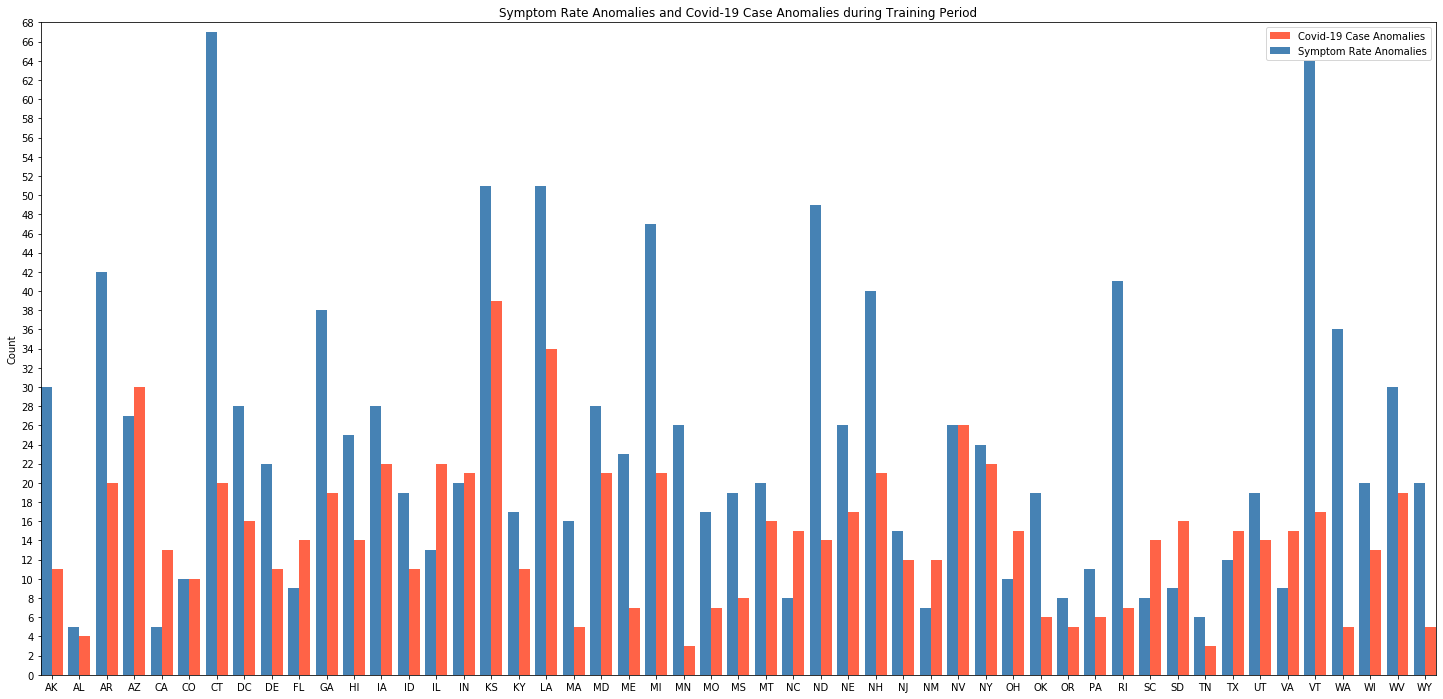

In [155]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(NUM_STATES)
X = [state[3:] for state in STATES]
ax.bar(_X + 0.2, [int(L_window) for L_window in total_real_anomalies], width=0.4, color='tomato', align='center', label="Covid-19 Case Anomalies")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP], width=0.4, color='steelblue', align='center', label="Symptom Rate Anomalies")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 70,2))
plt.title("Symptom Rate Anomalies and Covid-19 Case Anomalies during Training Period")
plt.ylabel("Count")
plt.legend()
plt.show()

## Experiment for DEBUGGING

In [27]:
new_delta_debug = np.concatenate((new_delta, new_delta_Jan21), axis=0)
L_hat_debug_period = new_delta_debug.shape[0]
print(L_hat_debug_period)

331


When TH is fixed and lag is 0

In [ ]:
for state in STATES: 
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0    
    target = get_target_region_idx(state)   
    L_debug = pred_outbreak_detection(new_delta, L_hat_period_all, 1).transpose()[target]
    L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, 1)
    all_S = comparison_all(state, L_debug, L_hat)
    metr = metrics(all_S, L_debug)
    print(state, metr[4])

In [ ]:
for state in STATES: 
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    
    target = get_target_region_idx(state)
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   
            
            idx = np.arange(l, l + L_hat_period_all)  
            window_delta = new_delta_debug[idx]
            L_debug = pred_outbreak_detection(window_delta, L_hat_period_all, 1).transpose()[target]
            
            
            L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, th)
            all_S = comparison_all(state, L_debug, L_hat)

            metr = metrics(all_S, L_debug)
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
    
    print(state + " " + str(best_f_score) + " lag " + str(best_th_lag[1]) + " th " + str(best_th_lag[0]))

In [ ]:
new_delta_lag = new_delta[10:]
L_hat_period_all = new_delta_lag.shape[0]

for state in STATES: 
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    
    target = get_target_region_idx(state)
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   
            
            
            new_delta = new_delta[10:]
            
            idx = np.arange(l, l + L_hat_period_all)  
            window_delta = new_delta_debug[idx]
            L_debug = pred_outbreak_detection(window_delta, L_hat_period_all, 1).transpose()[target]
            
            
            L_hat = pred_outbreak_detection(new_delta_lag, L_hat_period_all, th)
            all_S = comparison_all(state, L_debug, L_hat)

            metr = metrics(all_S, L_debug)
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
    
    print(state + " " + str(best_f_score) + " lag " + str(best_th_lag[1]) + " th " + str(best_th_lag[0]))

# EXPERIMENTATION 2: FALSE Anomalies

In [ ]:
# Histogram purposes
def covid_case_outbreak_detection_hist(X, target_region, minimum):
    X_target = X[X.state == target_region].drop(['date', 'state'], axis=1).to_numpy().flatten()
    X_target[X_target < 1] = 1
    assert np.any(X_target < 1) == False, "Actual Cases < 1"
    period = len(X_target) 
    C = np.zeros(period)
    for idx, X_day in enumerate(X_target):
        if idx == 0:
            continue  
        Cd = np.divide(np.subtract(X_day, X_target[idx-1]), X_target[idx-1])
        C[idx] = Cd   
    temp = np.copy(C)
    std_C = np.std(C)
    temp[temp > (3 * std_C)] = 0
    std_C = np.std(temp)
    assert std_C != 0, "Std C is 0"
    L_score = C > (2 * std_C)
    L_score = L_score.astype(int)
    anomaly_cases = np.array([X_target[idx] for idx, l in enumerate(L_score) if l == 1 and X_target[idx] < minimum])
    return anomaly_cases

# FOR ALL STATES
small_anoms = np.zeros(NUM_STATES)
actual_case_count_training = np.zeros(NUM_STATES)
for idx_s, state in enumerate(STATES):
    actual_case_count_training[idx_s] = np.sum(covid_case_outbreak_detection_all(actual_all, state[3:]))
    small_anoms[idx_s] = len(covid_case_outbreak_detection_hist(actual_all, state[3:], 50))

fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(NUM_STATES)
X = [state[3:] for state in STATES]
ax.bar(_X + 0.2, small_anoms, width=0.4, color='tomato', align='center', label="False Anomalies")
ax.bar(_X - 0.2, actual_case_count_training, width=0.4, color='steelblue', align='center', label="Anomalies")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.title("False Anomalies and Covid-19 Case Anomalies during Training Period")
plt.ylabel("Count")
plt.legend()
plt.show()

## Experiment 3: Linear Correlation

From 7 March 2020 - 31 Dec 2020

Aggregated

In [32]:
symptoms = F[(F.date >= '2020-03-07') & (F.date <= '2020-12-31')]
# (Symptom, Period)
symptoms_aggregated = symptoms.groupby('date').sum().to_numpy().transpose()

cases_for_corr_agg = actual_cases[(actual_cases.date >= '2020-03-07') & (actual_cases.date <= '2020-12-31')]
cases_for_corr_agg = cases_for_corr_agg.groupby('date').sum().to_numpy()
scaler = MinMaxScaler(feature_range=(0, 1))
normalised_cases = scaler.fit_transform(cases_for_corr_agg).flatten()

corr_agg = []
for idx_s, symp in enumerate(SYMP_LIST):
    corr_agg.append(np.array(stats.pearsonr(symptoms_aggregated[idx_s], normalised_cases)))

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

# Example data
y_pos = np.arange(NUM_SYMP)
ax.barh(y_pos, [c[0] for c in corr_agg], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels([s[8:] for s in SYMP_LIST])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Pearson Correlation, r')
ax.set_title('Pearson Correlation of Aggregated Symptom Rates and Aggregated New Covid-19 Cases')

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
x = symptoms_aggregated[-6]
ax.scatter(x, normalised_cases)
ax.set_xlabel('Aggregated Symptom Rate: Clouding of Consciousness')
ax.set_ylabel('Normalized Daily Covid-19 Cases')
ax.set_title('Symptom Rate: Clouding of Consciousness')
z = np.polyfit(x, normalised_cases, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

# EXPERIMENT 4: 2DP TH

In [180]:
LA = get_target_region_idx("US-LA")
test_delta_LA = new_delta_testing.transpose()[LA]

# TRAIN
state_lag = int(state_best_th_lag[LA][1])
state_th = 0.15

X_window_train_LA = window_X(actual_all, state_lag, L_hat_period_all, "LA")
L_window_train_LA = covid_case_outbreak_detection_all(X_window_train_LA)
print("OUTBREAK CASES", L_window_train_LA)
print()


L_hat_train_LA = pred_outbreak_detection(new_delta, L_hat_period_all, state_th)
print("OUTBREAK SR", np.sum(L_hat_train_LA.transpose()[LA]))
S_LA = comparison_all("US-LA", L_window_train_LA, L_hat_train_LA)
metr_train_LA = metrics(S_LA, L_window_train_LA)
print(metr_train_LA[2:])

OUTBREAK CASES [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0]

OUTBREAK SR 34
(0.4117647058823529, 0.4117647058823529, 0.4117647058823529)


In [186]:
# return TP_FP, FN, precision, recall, Fscore
TH_EXP4 = np.arange(0,2,0.01)
lag_EXP4 = np.arange(0,31)
final_best_th_lag_EXP4 = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    if idx_s % 5 == 0:
        print(idx_s)
    best_th_lag_EXP4 = np.zeros(2)
    best_lag_EXP4 = 0
    best_f_score_EXP4 = 0
    target = state[3:]
    
    for idx_l, l in enumerate(lag_EXP4):
        for idx_th, th in enumerate(TH_EXP4):        
            
            X_window = window_X(actual_all, l, L_hat_period_all, target)
            L_window = covid_case_outbreak_detection_all(X_window)
    
            L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, th)
        
            all_S = comparison_all(state, L_window, L_hat)
            metr = metrics(all_S, L_window)
            
            if metr[4] > best_f_score_EXP4:
                best_th_lag_EXP4[0] = th
                best_th_lag_EXP4[1] = l
                best_f_score_EXP4 = metr[4]
                
    final_best_th_lag_EXP4[idx_s] = best_th_lag_EXP4

0


/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


5
10
15
20
25
30
35
40
45
50


### Metrics EXP 3

In [187]:
state_TP_FP_EXP4 = np.zeros((NUM_STATES,2))
state_FN_EXP4 = np.zeros(NUM_STATES)
state_fscore_EXP4 = np.zeros(NUM_STATES)
state_precision_EXP4 = np.zeros(NUM_STATES)
state_recall_EXP4 = np.zeros(NUM_STATES)

total_real_anomalies_EXP4 = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]   
    state_lag_EXP4 = int(final_best_th_lag_EXP4[idx_s][1])
    state_th_EXP4 = final_best_th_lag_EXP4[idx_s][0]
    
    X_window = window_X(actual_all, state_lag_EXP4, L_hat_period_all, target)
    L_window = covid_case_outbreak_detection_all(X_window)
            
    L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, state_th_EXP4)
    
    all_S = comparison_all(state, L_window, L_hat)
    
    total_real_anomalies_EXP4[idx_s] = np.sum(L_window)
    metr = metrics(all_S, L_window)
    
    state_TP_FP_EXP4[idx_s] = metr[0]
    state_FN_EXP4[idx_s] = metr[1]
    state_precision_EXP4[idx_s] = metr[2]
    state_recall_EXP4[idx_s] = metr[3]
    state_fscore_EXP4[idx_s] = metr[4]

In [222]:
np.savetxt("state_TP_FP_EXP4.csv", state_TP_FP_EXP4, delimiter=",")
np.savetxt("state_FN_EXP4.csv", state_FN_EXP4, delimiter=",")
np.savetxt("state_precision_EXP4.csv", state_precision_EXP4, delimiter=",")
np.savetxt("state_recall_EXP4.csv", state_recall_EXP4, delimiter=",")
np.savetxt("state_fscore_EXP4.csv", state_fscore_EXP4, delimiter=",")
np.savetxt("total_real_anomalies_EXP4.csv", total_real_anomalies_EXP4, delimiter=",")
np.savetxt("state_best_th_lag_EXP4.csv", final_best_th_lag_EXP4, delimiter=",")

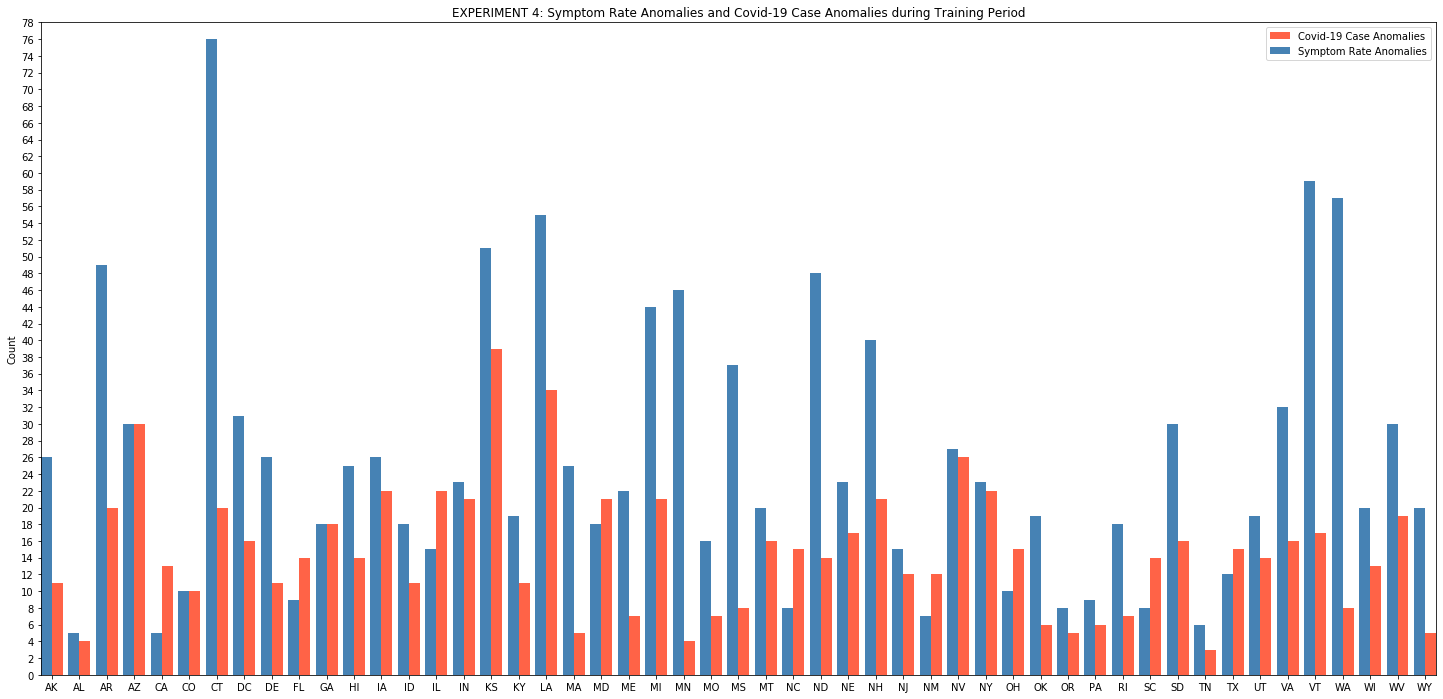

In [189]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(NUM_STATES)
X = [state[3:] for state in STATES]

ax.bar(_X + 0.2, [int(L_window) for L_window in total_real_anomalies_EXP4], width=0.4, color='tomato', align='center', label="Covid-19 Case Anomalies")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_EXP4], width=0.4, color='steelblue', align='center', label="Symptom Rate Anomalies")
ax.autoscale(tight=True)

plt.xticks(_X, X)
plt.yticks(range(0, 80,2))
plt.title("EXPERIMENT 4: Symptom Rate Anomalies and Covid-19 Case Anomalies during Training Period")
plt.ylabel("Count")
plt.legend()
plt.show()

In [221]:
print("LAG, TH, F", final_best_th_lag_EXP4[LA], state_fscore_EXP4[LA])
print("TP, FP", state_TP_FP_EXP4[LA])
print("FN", state_FN_EXP4[LA])


state_lag = 25
state_th = 0.13

X_window_train_LA = window_X(actual_all, state_lag, L_hat_period_all, "LA")
L_window_train_LA = covid_case_outbreak_detection_all(X_window_train_LA)
# print("OUTBREAK CASES", L_window_train_LA)
print()


L_hat_train_LA = pred_outbreak_detection(new_delta, L_hat_period_all, state_th)
# print("OUTBREAK SR", np.sum(L_hat_train_LA.transpose()[LA]))

S_LA = comparison_all("US-LA", L_window_train_LA, L_hat_train_LA)
metr_train_LA = metrics(S_LA, L_window_train_LA)
print(metr_train_LA)

LAG, TH, F [ 0.08 28.  ] 0.5168539325842696
TP, FP [23. 32.]
FN 11.0

(array([14., 26.]), 20.0, 0.35, 0.4117647058823529, 0.37837837837837834)


# Testing (Based on Exp 1)

## Preparing Data: L HAT

Testing period: 1 Jan 2021 - 5 February 2021 (36 days)

In [128]:
new_delta_testing = np.concatenate((new_delta_Jan21, new_delta_Feb21[:5]), axis=0)
testing_period = len(new_delta_testing)
print(testing_period, "days")

test_ave_mat = average_delta(testing_period, new_delta_testing)
test_std_mat = std_dev_delta(testing_period, new_delta_testing)

36 days


In [129]:
actual_testing = actual_cases_testing[(actual_cases_testing.date >= "2020-12-31") & (actual_cases_testing.date <= "2021-03-07")]
print(actual_testing.date.nunique(), "days")
#REMEMBER TO EXCLUDE L[0]! (31st Dec 2020)

67 days


In [112]:
def z_score_test(delta_region_day, ave, std, period):
    z_score = np.zeros(period)
    for idx_d, delta in enumerate(delta_region_day):
        z_day = np.divide(np.subtract(delta, ave), std)
        z_score[idx_d] = z_day
    return z_score

def comparison_test(L_window, L_hat_region):
    period = len(L_hat_region) 

    Lw = np.zeros(7)
    S = np.zeros((period, 2))
    
    counted = []
    for idx_L, L_hat_day in enumerate(L_hat_region): 
        if idx_L < 3: 
            w = np.arange(0, (idx_L+4))
        elif idx_L >= (period-3):
            w = np.arange((idx_L-3), period)
        else: 
            w = np.arange((idx_L-3), (idx_L+4))
            
        Lw = L_window[w]
        s = np.zeros(2)
        if L_hat_day == 1:
            L_outbreaks = np.argwhere(Lw == 1).flatten()
            date_idx_L_outbreaks = w[L_outbreaks]
            new_outbreaks = np.setdiff1d(date_idx_L_outbreaks, np.array(counted))
            if new_outbreaks.shape[0] > 0:
                idx_outbreak = new_outbreaks[0]
                s[0] = 1
                counted.append(idx_outbreak)
            else:
                s[1] = 1
        S[idx_L] = s
    return S

def test(test_delta, actual_testing, testing_period, ave_mat, std_mat, best_th_lag):
    f_score = np.zeros(NUM_STATES)
    TP_FP = np.zeros((NUM_STATES,2))
    FN = np.zeros(NUM_STATES)
    true_anomalies = np.zeros(NUM_STATES)
    
    for idx_s, state in enumerate(STATES):
        target = state[3:]
        lag = int(best_th_lag[idx_s][1])
        th = best_th_lag[idx_s][0]
                    
        X_window = window_X(actual_testing, lag, testing_period, target)
        L_window = covid_case_outbreak_detection_all(X_window)
        assert L_window.shape[0] == testing_period, "L length issue"
        
        test_delta_region = test_delta.transpose()[idx_s]
        z_score_region = z_score_test(test_delta_region, ave_mat[idx_s], std_mat[idx_s], testing_period)
        L_hat_testing = L_score(z_score_region, th) 
        
        S_test = comparison_test(L_window, L_hat_testing)
        met = metrics(S_test, L_window)
        
        true_anomalies[idx_s] = np.sum(L_window)
        f_score[idx_s] = met[4]
        TP_FP[idx_s] = met[0]
        FN[idx_s] = met[1]
    return f_score, TP_FP, FN, true_anomalies

In [113]:
f_test, TP_FP_test, FN_test, L_window_sum = test(new_delta_testing, actual_testing, testing_period, test_ave_mat, test_std_mat, state_best_th_lag)

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


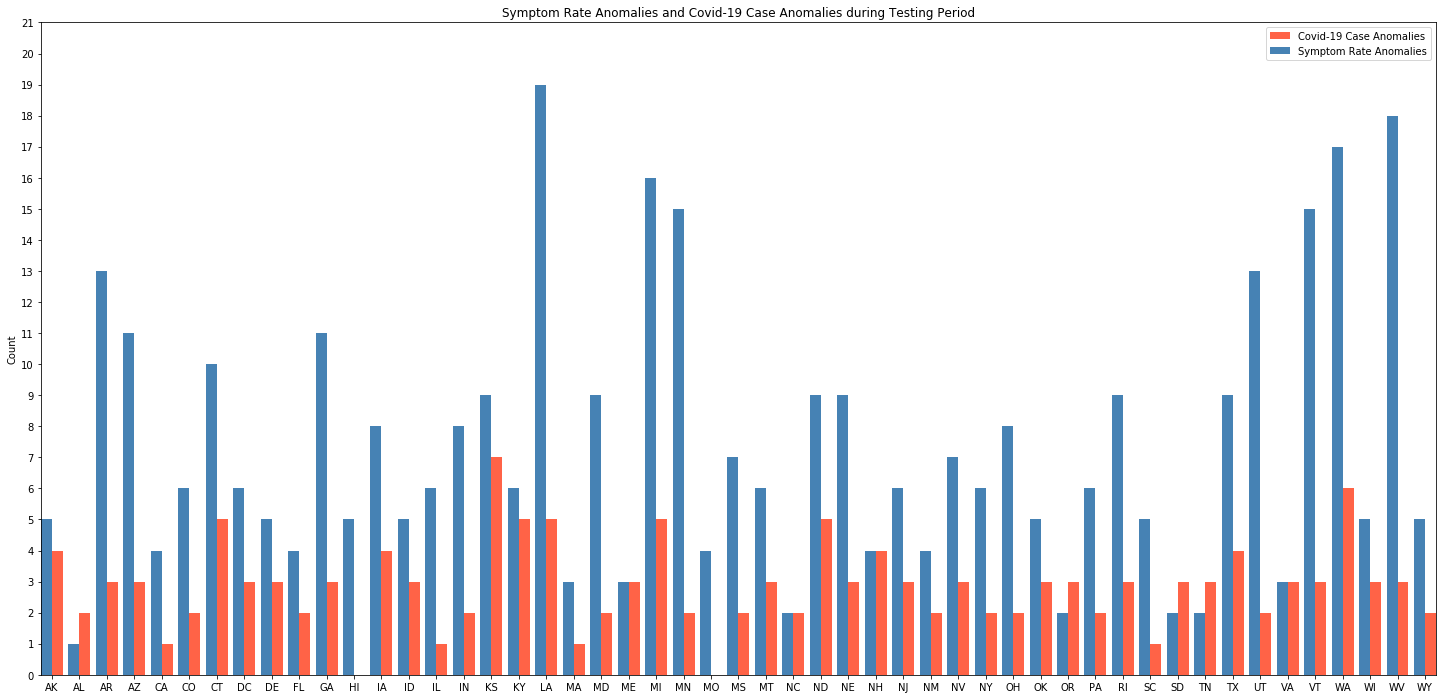

In [114]:
# plt.figure(figsize=(24,8))
# plt.title("Number of Covid-19 Case Anomalies from January 1st to March 3rd by State")
# plt.ylabel("Count")
# plt.bar([states[3:] for states in STATES], L_window_sum)

fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(NUM_STATES)
X = [state[3:] for state in STATES]
ax.bar(_X + 0.2, [int(L_window) for L_window in L_window_sum], width=0.4, color='tomato', align='center', label="Covid-19 Case Anomalies")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in TP_FP_test], width=0.4, color='steelblue', align='center', label="Symptom Rate Anomalies")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 22))
plt.title("Symptom Rate Anomalies and Covid-19 Case Anomalies during Testing Period")
plt.ylabel("Count")
plt.legend()
plt.show()

Saving values

In [115]:
np.savetxt("f_test.csv", f_test, delimiter=",")
np.savetxt("TP_FP_test.csv", TP_FP_test, delimiter=",")
np.savetxt("FN_test.csv", FN_test, delimiter=",")
np.savetxt("L_window_sum_test.csv", L_window_sum, delimiter=",")

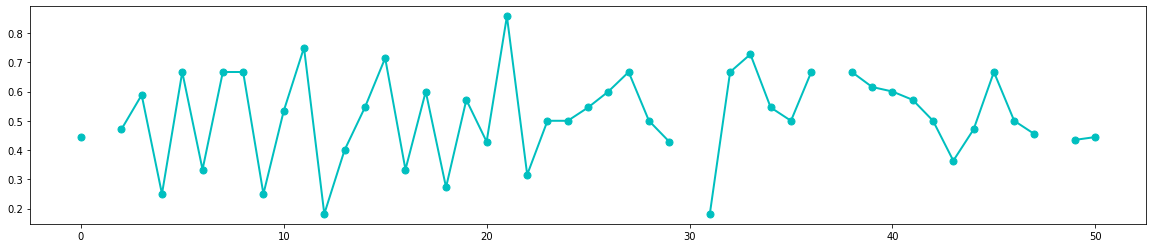

In [34]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(4)
fig.set_figwidth(20)
all = ax.plot(np.array(range(len(f_test))),f_test, marker='o',  markersize=7, color='c', linewidth=2)

### Why does LA have so many predictions during Training period?

OUTBREAK CASES [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0]

OUTBREAK SR 34
(0.4117647058823529, 0.4117647058823529, 0.4117647058823529)
